# Classifying emotions in movie dialogue using Watson NLP - custom models

This notebook demonstrates how to classify emotions in tweets using Watson NLP python library

### What you'll learn in this notebook
Watson NLP offers so-called blocks for various NLP tasks. This notebook shows:

- **Syntax analysis** with the _Syntax block_ for English (`syntax_izumo_en_stock`). This block performs tokenization, lemmatization, parts of speech tagging, and dependency parsing on raw input documents so that custom models can properly classify documents.
- **Emotion classification** with the _TF-IDF_, _Embeddings_, and _CNN_ models in Watson NLP. These model workflow classify text into five emotions: "sadness", "happiness", "neutral", "anger", "fear", "disgust".

## Table of Contents

1.  [Before you start](#beforeYouStart)
1.	[Data Loading](#loadData)
1.  [Data Processing](#dataProcessing)
    1. [Data formatting](#dataFormat)
    1. [Train test split](#trainTestSplit) 
    1. [Pre-processing](#preProcessing)
1.  [Model Building](#modelBuilding)
    1. [TF-IDF](#tfidf)
    1. [Embeddings](#embeddings)
    1. [CNN](#cnn)
1.  [Model Evaluation](#modelEvaluation)
1.  [Summary](#summary)

<a id="beforeYouStart"></a>
## 1. Before you start

<div class="alert alert-block alert-danger">
<b>Stop kernel of other notebooks.</b></div>

**Note:** If you have other notebooks currently running with the _Default Python 3.8 + Watson NLP XS_ environment, **stop their kernels** before running this notebook. All these notebooks share the same runtime environment, and if they are running in parallel, you may encounter memory issues. To stop the kernel of another notebook, open that notebook, and select _File > Stop Kernel_.

<div class="alert alert-block alert-warning">
<b>Set Project token.</b></div>

Before you can begin working on this notebook in Watson Studio in Cloud Pak for Data as a Service, you need to ensure that the project token is set so that you can access the project assets via the notebook.

When this notebook is added to the project, a project access token should be inserted at the top of the notebook in a code cell. If you do not see the cell above, add the token to the notebook by clicking **More > Insert project token** from the notebook action bar.  By running the inserted hidden code cell, a project object is created that you can use to access project resources.

![ws-project.mov](https://media.giphy.com/media/jSVxX2spqwWF9unYrs/giphy.gif)
<div class="alert alert-block alert-info">
<b>Tip:</b> Cell execution</div>

Note that you can step through the notebook execution cell by cell, by selecting Shift-Enter. Or you can execute the entire notebook by selecting **Cell -> Run All** from the menu.

<span style="color:blueviolet">Begin by importing and initializing some helper libs that are used throughout the notebook.</span>


In [2]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
import watson_nlp
import watson_nlp.data_model as dm

from sklearn.model_selection import train_test_split

from watson_core.toolkit import fileio
from watson_core.toolkit.quality_evaluation import QualityEvaluator, EvalTypes

from watson_nlp.blocks.classification.bert import BERT
from watson_nlp.blocks.classification.cnn import CNN
from watson_core.data_model.streams.resolver import DataStreamResolver
from watson_core.data_model.streams.resolver import DataStream
from watson_nlp.blocks.classification.svm import SVM
from watson_nlp.blocks.vectorization.tfidf import TFIDF

In [3]:
pd.set_option('display.max_colwidth', 0)

<span style="color:maroon">Printing either `block_models` or `workflow_models` will display a list of pretrained models available in the current version of Watson NLP</span>

In [4]:
block_models = watson_nlp.get_models().get_alias_models()
workflow_models = watson_nlp.get_workflows().get_alias_models()

<a id="loadData"></a>
## 2. Data Loading

The dataset contains over seven thousand quotations from tweets. The labeled emotions in the dataset are "anger", "sadness", "fear", "joy", and "disgust". Because some quotations have multiple sentences, they can be regarded as documents. The dataset is available internally at [Github Repo](https://github.ibm.com/hcbt/Watson-NLP/blob/main/Emotion-Classification/emotion_tweets.csv). The original source of this dataset is from [Kaggle](https://www.kaggle.com/datasets/anjaneyatripathi/emotion-classification-nlp?select=emotion-labels-train.csv) with a CC0: Public Domain license.
<br><br>
Any other emotion classification dataset may be used in substitution for the workflow outlined in this notebook.

Data format:
- .csv file that is loaded as a Pandas DataFrame with two columns, `text` and `label`

Data dictionary:
- text: string; text of tweets; this will be used as the input for models
- label: string; emotion class labels; this will be the what the model is trying to accurately predict

In [5]:
# load data set into a dataframe
buffer = project.get_file("emotion-tweets.csv")
df = pd.read_csv(buffer)

<a id="dataFormat"></a>
### 3.1. Data formatting

<span style="color:blue">Data prepared for Watson NLP models need to be formatted in such a way that there is a `text` feature column and a `labels` label column. The `labels` column needs have type `list`.</span>

In [6]:
def convertToList(x):
    return [x]

In [7]:
df['label'] = df['label'].apply(convertToList)
df = df.rename(columns={'label':'labels'})

<a id="trainTestSplit"></a>
### 3.2. Train Test Split

<div class="alert alert-block alert-info">
<b>Tip:</b> If you want to carry out emotion analysis on any other dataset, you should first upload the dataset into the project and then update the name of the file in the next cell</div>
<br>

<span style="color:blue">The data will be split into an 80/20 train-test split using sklearn and then exported into JSON format for the Watson NLP models to consume. Additionally, the column headers will be renamed to the expected `text` and `labels` names, with the labels having type list.</span>

In [8]:
df_train, df_test = train_test_split(df, test_size=0.2)

In [9]:
df_train.to_json('df_train.json', orient='records')
df_test.to_json('df_test.json', orient='records')

In [10]:
df_train

,text,labels
2954,Smokeys dad is sad :/,[sadness]
4205,"It take so little to make a child's life joyful, why do we work so hard to make their lives hell? @MiddleEastEye Peace",[joy]
909,"@gdimelow @TheDailyShow @NivenJ1 @jordanklepper These interviews scare the crap out of me. I never imagined so many dumb, dumb Americans.",[fear]
2327,@girlsreallyrule Both Trump + King are relentless self-promoters who don't give a rip about anyone else. A perfect match for both Donalds.,[anger]
3020,@ATTCares why do I have 2 wait 48 hours to call YOU back to cancel an order I JUST placed after already spending 2 hours on the phone?! #sad,[sadness]
...,...,...
3081,The voice is all about Miley and Alicia this year. No longer about the contestants. #sad @thevoice,[sadness]
6200,@LdhranOusby @RobHarris inclined to think that 'documentary' did him more harm than good. If not I despair of people's critical faculties.,[sadness]
4029,"Yesterday is history, tomorrow is amystery, and today is a gift; that's why they call it the present #livelife #humbleness #live",[joy]
4746,"Bilal Abood, #Iraq #immigrant who lives in Mesquite, Texas, was sentenced to 48 months in prison for lying to the Feds about #terrorism.",[fear]


<a id="preProcessing"></a>
### 3.3. Pre-Processing

<span style="color:blue">The pre-processing step converts the training dataset into a a data stream for Watson NLP consumption. 
The training data is then run through a syntax model to perform tokenization and lemmatization.
The following three models will all use this syntax processed data as training data.</span>

In [11]:
training_data_file = "df_train.json"

# Create datastream from training data
data_stream_resolver = DataStreamResolver(target_stream_type=list, expected_keys={'text': str, 'labels': list})
training_data = data_stream_resolver.as_data_stream(training_data_file)

# Load a Syntax model
syntax_model = watson_nlp.load(watson_nlp.download('syntax_izumo_en_stock'))

# Create Syntax stream
text_stream, labels_stream = training_data[0], training_data[1]
syntax_stream = syntax_model.stream(text_stream)

<a id="modelBuilding"></a>
## 4.  Model building

<span style="color:blue">There are three custom classification models in the follow sections. TF-IDF and Embeddings SVM models are trained and saved but not used in the testing section. They can be tested as a bonus. The CNN model is set up to be fine tuned and tested on the test split.</span>
<br>
<br>
<span style="color:blueviolet">The `model.save()` function will save the model as a directory populated with a config.yaml and an artifacts folder. The model will save in the current working directory where this notebook was launched, unless otherwise specified in the model name.</span>

<a id="tfidf"></a>
### Training with TF-IDF

In [12]:
# Train the TF-IDF vectorizer
tf_idf_model = TFIDF.train(syntax_stream)
tfidf_train_stream = tf_idf_model.stream(syntax_stream)
tfidf_svm_train_stream = watson_nlp.data_model.DataStream.zip(tfidf_train_stream, labels_stream)

# Train SVM using TF-IDF training stream
tfidf_classification_model = SVM.train(tfidf_svm_train_stream)

In [13]:
tfidf_classification_model.save('model_tfidf_emo_classification')

<a id="embeddings"></a>
### Training with Embeddings

In [14]:
use_embedding_model = watson_nlp.download_and_load('embedding_use_en_stock')
use_train_stream = use_embedding_model.stream(syntax_stream, doc_embed_style='raw_text')
# `raw_text`: run the universal sentence encoder over your text as one large chunk
# `ave_sent`: independently run the universal sentence encoder over each of your sentences and average the results to 
#             produce a document embedding
use_svm_train_stream = watson_nlp.data_model.DataStream.zip(use_train_stream, labels_stream)

# Train SVM using Universal Sentence Encoder (USE) training stream
embeddings_classification_model = SVM.train(use_svm_train_stream)

In [15]:
embeddings_classification_model.save('model_embeddings_emo_classification')

<a id="cnn"></a>
### Training with CNN
<span style="color:maroon">These hyperparameters can be used in the pre-trained models to tune them too.</span>

In [16]:
training_data_file = "df_train.json"

# Load glove embeddings
glove_embedding_model = watson_nlp.download_and_load('embedding_glove_en_stock')

# Train CNN
cnn_classification_model = CNN.train(DataStream.zip(syntax_stream, labels_stream), 
                                     embedding=glove_embedding_model.embedding, 
                                     batch_size=128, 
                                     filter_sizes=(1, 2, 2), 
                                     num_filters=256, 
                                     epochs=10, 
                                     random_seed=1001, 
                                     enable_tensorboard=False, 
                                     dropout_prob=0.5, 
                                     l2_reg_lambda=0.01, 
                                     verbose=1, 
                                     multi_label=False, )

Epoch 1/10
45/45 [==============================] - 39s 762ms/step - loss: 4.7646 - categorical_accuracy: 0.3216
Epoch 2/10
45/45 [==============================] - 37s 739ms/step - loss: 2.8862 - categorical_accuracy: 0.4872
Epoch 3/10
45/45 [==============================] - 38s 749ms/step - loss: 1.9148 - categorical_accuracy: 0.6215
Epoch 4/10
45/45 [==============================] - 37s 742ms/step - loss: 1.3622 - categorical_accuracy: 0.7131
Epoch 5/10
45/45 [==============================] - 38s 747ms/step - loss: 1.0424 - categorical_accuracy: 0.7699
Epoch 6/10
45/45 [==============================] - 38s 750ms/step - loss: 0.8438 - categorical_accuracy: 0.8106
Epoch 7/10
45/45 [==============================] - 38s 754ms/step - loss: 0.7113 - categorical_accuracy: 0.8396
Epoch 8/10
45/45 [==============================] - 37s 741ms/step - loss: 0.6162 - categorical_accuracy: 0.8645
Epoch 9/10
45/45 [==============================] - 38s 751ms/step - loss: 0.5438 - categorical_

In [17]:
cnn_classification_model.save('emotion_cnn_model')

<span style="color:blueviolet">By using `project.save_data()`, the model will be saved as an object into the Data Assets of the Watson Studio project.</span>

In [18]:
project.save_data('emotion_cnn_model', data=cnn_classification_model.as_file_like_object(), overwrite=True)

{'file_name': 'model_cnn_emo_classification',
 'message': 'File saved to project storage.',
 'bucket_name': 'watsoncore-donotdelete-pr-olkxvfa8bk0pb1',
 'asset_id': '01cec751-70f6-4dd9-8e8c-2f3818ddb267'}

<a id="modelEvaluation"></a>
## 5. Model Evaluation
<span style="color:blue">The first step in testing the model is to load in the previously saved classification model. Then, just like with the training data, the testing data will need to be processed by the syntax model for tokenization and lemmatization. Finally, the `model.evaluate_quality()` function will run predictions on the data.</span>

In [19]:
test_data_file = "df_test.json"

# Load a Syntax model
syntax_model = watson_nlp.load(watson_nlp.download('syntax_izumo_en_stock'))

# Load classification model
classification_model = watson_nlp.load('emotion_cnn_model')

# Setup pre-processing function
preprocess_func = lambda raw_doc: syntax_model.run_batch(raw_doc)

quality_report = classification_model.evaluate_quality(test_data_file, preprocess_func)

In [20]:
print(json.dumps(quality_report, indent=4))

{
    "per_class_confusion_matrix": {
        "sadness": {
            "true_positive": 216,
            "false_positive": 77,
            "false_negative": 79,
            "precision": 0.7372013651877133,
            "recall": 0.7322033898305085,
            "f1": 0.7346938775510204
        },
        "fear": {
            "true_positive": 386,
            "false_positive": 89,
            "false_negative": 85,
            "precision": 0.8126315789473684,
            "recall": 0.8195329087048833,
            "f1": 0.8160676532769556
        },
        "joy": {
            "true_positive": 285,
            "false_positive": 45,
            "false_negative": 37,
            "precision": 0.8636363636363636,
            "recall": 0.8850931677018633,
            "f1": 0.8742331288343559
        },
        "anger": {
            "true_positive": 259,
            "false_positive": 64,
            "false_negative": 74,
            "precision": 0.8018575851393189,
            "recall": 0.77777

<span style="color:blueviolet">With the same single input, the CNN model predicts `happiness` with higher confidence than pre-trained models.</span>

In [21]:
syntax_prediction = syntax_model.run("Such a sweet boy. But after much thought and careful consideration, I've decided that the ruler for the next ten thousand years is going to have to be... me. ")
classifier_result = classification_model.run(syntax_prediction)
print(classifier_result)

{
  "classes": [
    {
      "class_name": "sadness",
      "confidence": 0.4560098350048065
    },
    {
      "class_name": "fear",
      "confidence": 0.31765231490135193
    },
    {
      "class_name": "joy",
      "confidence": 0.16058361530303955
    },
    {
      "class_name": "anger",
      "confidence": 0.0657542496919632
    }
  ],
  "producer_id": {
    "name": "CNN classifier",
    "version": "0.0.1"
  }
}


In [22]:
# Another option for saving the model
'''
import pickle
with open ('model_cnn_emo_classification.pkl', 'wb') as f:
    pickle.dump(classification_model.as_file_like_object(), f)
'''

"\nimport pickle\nwith open ('model_cnn_emo_classification.pkl', 'wb') as f:\n    pickle.dump(classification_model.as_file_like_object(), f)\n"

<span style="color:blue">By parsing out the results of the model runs, we can visualize the difference between predicted labels and actual labels.</span>

In [23]:
def run_emotion(text):
    emotion_result = classification_model.run(syntax_model.run(text))
    emo_dict = {emo.class_name:emo.confidence for emo in emotion_result.classes}
    return emo_dict

In [24]:
test_df = pd.read_json(test_data_file)
test_df['label'] = test_df['labels'].str[0]

In [25]:
output = []
for line in test_df['text']:
    output.append([line, run_emotion(line)])

In [26]:
emotion_df = pd.DataFrame(output, columns=['text', 'emotions'])
emotion_df = pd.concat([emotion_df, emotion_df["emotions"].apply(pd.Series)], axis=1)
emotion_df = emotion_df.drop(['emotions'], axis=1)
emotion_df['highest_emotion'] = emotion_df[['joy', 'anger', 'sadness', 'fear']].idxmax(axis=1)

Text(0.5, 1.0, 'Test dataset labels')

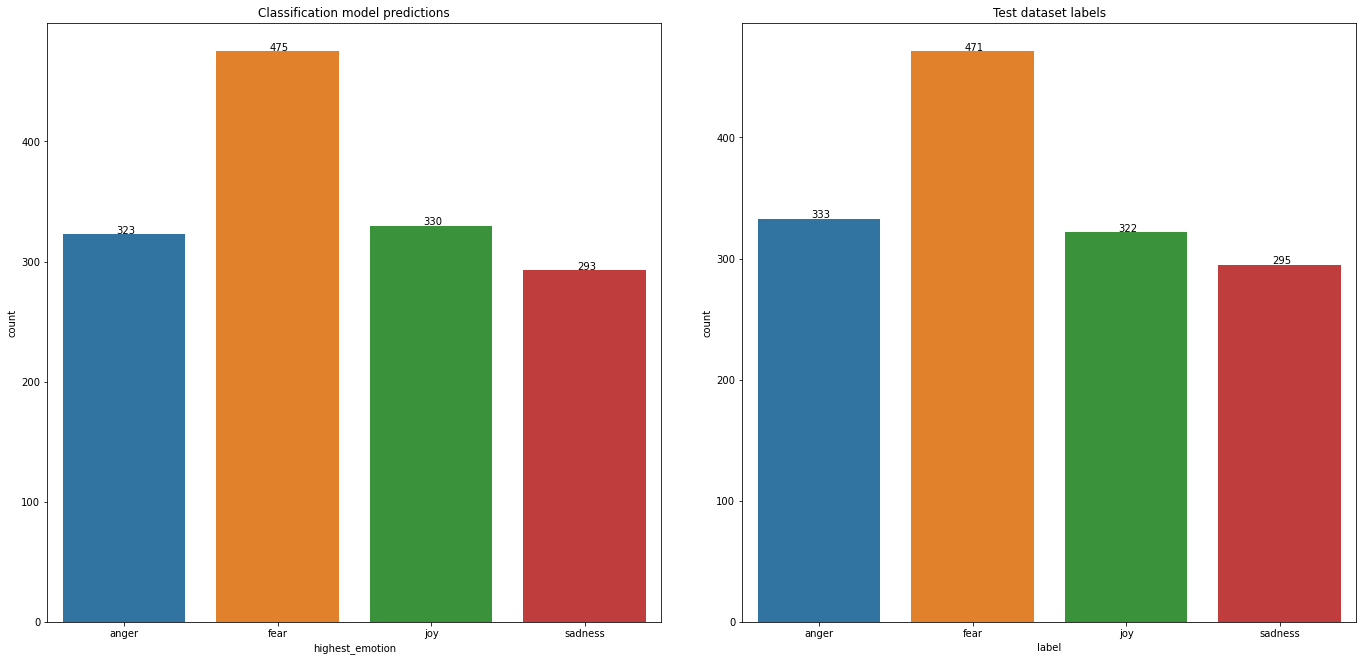

In [27]:
figure, ax = plt.subplots(ncols=2, figsize=(20,10))
figure.tight_layout(pad=5)
sns.countplot(x=emotion_df['highest_emotion'],  data=emotion_df['highest_emotion'], order=emotion_df['highest_emotion'].value_counts().sort_index().index, ax=ax[0])
for p, label in zip(ax[0].patches, emotion_df['highest_emotion'].value_counts().sort_index()): 
    ax[0].annotate(label, (p.get_x()+0.35, p.get_height()+0.5))
ax[0].set_title('Classification model predictions')

sns.countplot(x=test_df["label"],  data=test_df["label"], order=test_df["label"].value_counts().sort_index().index, ax=ax[1])
for p, label in zip(ax[1].patches, test_df["label"].value_counts().sort_index()):   
    ax[1].annotate(label, (p.get_x()+0.35, p.get_height()+0.5))
ax[1].set_title('Test dataset labels')

## 6. Summary

<span style="color:blue">This notebook shows you how to use the Watson NLP library and how quickly and easily you can get started with Watson NLP by fine tuning deep learning models for emotion analysis.

Please note that this content is made available by IBM Build Lab to foster Embedded AI technology adoption. The content may include systems & methods pending patent with USPTO and protected under US Patent Laws. For redistribution of this content, IBM will use release process. For any questions please log an issue in the hosting [GitHub](https://github.com/ibm-build-labs/Watson-NLP) repository. 

Developed by IBM Build Lab 

Copyright - 2022 IBM Corporation 